# 4-Class Popularity Range Prediction from Spotify Song Audio Features

## Introduction

When it comes to data about music, Spotify is one of the giants. Not only do they utilize sophisticated audio analysis processes to recognize distinct features in a song, but they also make this data readily available to anyone with the time and knowhow. Normally, it is rather cumbersome to gather the audio features data through the API, as you can only get 100 songs per API call, and you have to have each song's unique ID, so you really have to know exactly what songs you're looking for. Thankfully, however, I found a dataset on <a href="https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db">Kaggle</a> that has over 232K songs, with a diverse selection of nearly 10K songs for each of the 26 genres represented.

## Initialize and Import Data

In [1]:
# Initialize the environment
import time
import numpy as np
import pandas as pd

In [2]:
#Import the data
df = pd.read_csv("~/projects/spotify-song-popularity/ultimate-spotify-tracks-db.zip")

## Exploration

In [3]:
df.sample(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
102248,Children’s Music,Three Days Grace,Chasing The First Time,5waEr0KFm3f3mnAI7qDUfY,53,0.00338,0.463,175613,0.936,0.000000,D,0.365,-3.458,Minor,0.0989,75.497,4/4,0.4030
225109,Rock,OneRepublic,Something I Need,4KANJH1baadr3U7XsVbM17,57,0.16400,0.683,241267,0.601,0.000000,G,0.119,-6.927,Major,0.0308,98.970,4/4,0.6200
75501,Children's Music,Juice Music,We Will Rock You,0j1vdTvZ6GahC6emB1fUhc,0,0.07510,0.848,147640,0.411,0.000066,E,0.110,-10.447,Minor,0.1460,90.974,4/4,0.2690
19511,Dance,P!nk,Trouble,19mgPZ6GYOmozgEh56YhFP,45,0.00680,0.572,191880,0.932,0.000000,G,0.491,-2.700,Major,0.0479,135.522,4/4,0.8530
106916,Opera,Giacomo Puccini,Il Tabarro: Dimmi: perchè gli hai chiesto,7CutY2mf7ERdInX9kD6vBU,2,0.97000,0.333,272373,0.302,0.004180,A,0.361,-15.888,Major,0.0625,120.356,3/4,0.0766


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
genre               232725 non-null object
artist_name         232725 non-null object
track_name          232725 non-null object
track_id            232725 non-null object
popularity          232725 non-null int64
acousticness        232725 non-null float64
danceability        232725 non-null float64
duration_ms         232725 non-null int64
energy              232725 non-null float64
instrumentalness    232725 non-null float64
key                 232725 non-null object
liveness            232725 non-null float64
loudness            232725 non-null float64
mode                232725 non-null object
speechiness         232725 non-null float64
tempo               232725 non-null float64
time_signature      232725 non-null object
valence             232725 non-null float64
dtypes: float64(9), int64(2), object(7)
memory usage: 32.0+ MB


Apparently no nulls, so that is good. I'll do a df.describe() to make sure there are no erroneous numerical values.

In [5]:
df.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,232725.000000,232725.000000,232725.000000,2.327250e+05,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000,232725.000000
mean,41.127502,0.368560,0.554364,2.351223e+05,0.570958,0.148301,0.215009,-9.569885,0.120765,117.666585,0.454917
std,18.189948,0.354768,0.185608,1.189359e+05,0.263456,0.302768,0.198273,5.998204,0.185518,30.898907,0.260065
min,0.000000,0.000000,0.056900,1.538700e+04,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.037600,0.435000,1.828570e+05,0.385000,0.000000,0.097400,-11.771000,0.036700,92.959000,0.237000
50%,43.000000,0.232000,0.571000,2.204270e+05,0.605000,0.000044,0.128000,-7.762000,0.050100,115.778000,0.444000
75%,55.000000,0.722000,0.692000,2.657680e+05,0.787000,0.035800,0.264000,-5.501000,0.105000,139.054000,0.660000
max,100.000000,0.996000,0.989000,5.552917e+06,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


## Cleaning

Looks like "duration_ms" is using a much larger type of integer for a number that only reaches about 5.5 million at the most in this dataset, so I'll change it to an int32, which has a max value of 2147483647, and uses half the memory.

In [6]:
df['duration_ms'] = df['duration_ms'].astype("uint32")

Since "popularity" only ranges from 0-100, we can use an unsigned 8 bit integer, which has a range of 0-255.

In [7]:
df['popularity'] = df['popularity'].astype("uint8")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
genre               232725 non-null object
artist_name         232725 non-null object
track_name          232725 non-null object
track_id            232725 non-null object
popularity          232725 non-null uint8
acousticness        232725 non-null float64
danceability        232725 non-null float64
duration_ms         232725 non-null uint32
energy              232725 non-null float64
instrumentalness    232725 non-null float64
key                 232725 non-null object
liveness            232725 non-null float64
loudness            232725 non-null float64
mode                232725 non-null object
speechiness         232725 non-null float64
tempo               232725 non-null float64
time_signature      232725 non-null object
valence             232725 non-null float64
dtypes: float64(9), object(7), uint32(1), uint8(1)
memory usage: 29.5+ MB


Shaved off 2.5MB, which may not seem like a lot now, but when the dataset gets larger, every little bit counts.

I don't need the first four columns, since I do not care about artist, track name, or ID, and I'm not taking the genre into consideration for this model, as there will already be a lot of one-hot encoded features added just from two of the columns, "key" and "time signature".
First, I'll drop the first four columns before getting dummies.

In [9]:
df.drop(["genre", "artist_name", "track_id", "track_name"], 1, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 14 columns):
popularity          232725 non-null uint8
acousticness        232725 non-null float64
danceability        232725 non-null float64
duration_ms         232725 non-null uint32
energy              232725 non-null float64
instrumentalness    232725 non-null float64
key                 232725 non-null object
liveness            232725 non-null float64
loudness            232725 non-null float64
mode                232725 non-null object
speechiness         232725 non-null float64
tempo               232725 non-null float64
time_signature      232725 non-null object
valence             232725 non-null float64
dtypes: float64(9), object(3), uint32(1), uint8(1)
memory usage: 22.4+ MB


## Feature Engineering

First, before I into feature engineering, I will provide explanations for each of the features.
* **Popularity** (the outcome variable): A score from 0-100. This metric is based on how many listens a song gets, and each listen is weighted based on how recent it is. The more recent a listen, the more it impacts a song's popularity score. This is a dynamically's changing score, and if one were to maintain a full audio feature's database of every Spotify song, it would be advised to pull the entire catalog at least once a year to keep up with current popularity scores, influenced by listening trends. If I were to do it, I would ensure that every song was released last year, so the song has had at least a year to be listened to, especially for newer, independent artists that need time to get exposure.

The audio feature descriptions below were pulled from Spotify's API <a href="https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/">documentation</a>, for the sake of saving time.

* **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* **Danceability**: Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.
* **Duration in milliseconds**: Self explanatory.
* **Energy**: A measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
* **Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
* **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
* **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
* **Speechiness**: Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
* **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
* **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

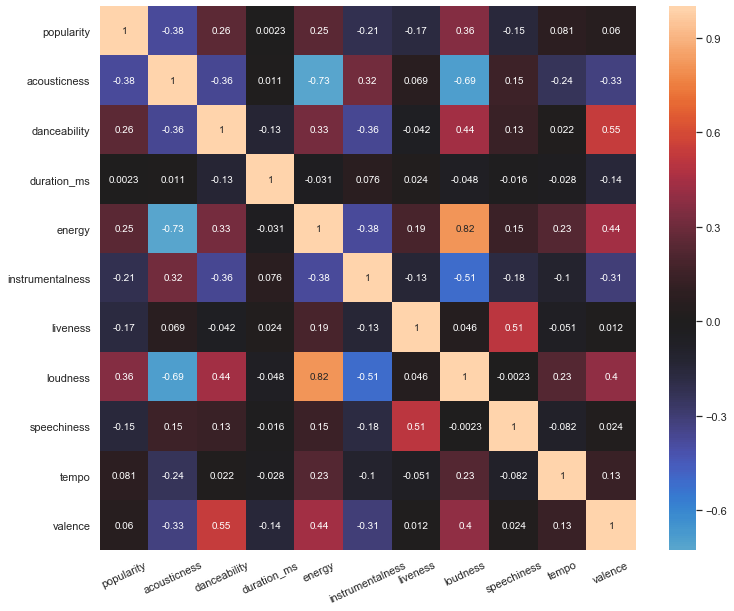

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), center=0, annot=True)
plt.xticks(rotation=25)
plt.show()

A lot can be said about this heatmap when it comes to how all the input features correlate with eachother, but since I only care about how they interact with the outcome variable, I will discuss their correlations.

**Detractors**

* **Acousticness**: With -0.38, it seems that the acousticness of a track is the greatest detractor of popularity in this dataset. This is not too surprising, as a lot of classical and folk music have high scores in this feature, while most popular music these days has a lot of electronic instruments.
* **Instrumentalness**: With -0.21, this is the second greatest detractor to popularity. It seems that the absence of lyrics does not help a song's popularity. Perhaps the lack of lyrics makes a song less relatable to most people?
* **Liveness**: With -0.17, this is the third greatest detractor to popularity. I would postulate that this is due to most live versions of songs not sounding as well produced than the studio version. Perhaps the crowd noise is also a turn-off for most people that just want to enjoy the music?
* **Speechiness**: With -0.15, this is the fourth greatest detractor to popularity. This may show that many people on Spotify just want to listen to music, and not to podcasts or comedy routines, which are just some of the kinds of tracks that have a high degree "speechiness."

**Contributors**

* **Loudness**: At 0.36, this is the greatest contributor to popularity. It makes sense, as if a song isn't well-mastered, and thus not having the capacity for a greater perceived volume, it may be hard for the listener to appreciate all of the nuances and elements of a song.
* **Danceability**: At 0.26, this is the second greatest contributor to popularity. This follows intuition, as more danceable a track is, the beat is steady and easier for the listener to follow, thus being more accessible to a larger audience. Also, if a track is easier to dance to, it allows for listeners to play the track while they do an athletic activity, as it helps them keep a steady pace, and also makes it more likely to be played in public places, like clubs, bars, and retail stores.
* **Energy**: At a close third, with 0.25, it goes along with my previous assessment of "Danceability", listeners will enjoy playing a track with higher energy during the day when they want to be most active.
* **Tempo**: At a more distant 0.081, the tempo of a track plays a seemingly minor, but important role, as if it a song is too slow, a listener will be bored, and if it is too fast, they will be overwhelmed.
* **Valence**: At 0.06, happier sounding tracks are a little bit more popular, and this may make sense as the general population wants to be uplifted by their music most of the time, though at times they may want to listen to something more fitting to their current mood.
* **Duration**: At a very minor 0.0023, it may not seem to contribute much, but listeners may grow bored if a song is too long, or end up skipping really short songs that are used as intros, outros, or interludes on an album.

### Encoding

Presently, mode, which determines whether a song is in a major or minor key, is not in numerical format, so it needs to be binary, 0 for "Minor" and 1 for "Major. I will also convert it to uint8 to save more memory. 

In [15]:
df["mode"].mask(df["mode"] == 'Minor', 0, inplace=True)
df["mode"].mask(df["mode"] == 'Major', 1, inplace=True)

In [18]:
df['mode'] = df['mode'].astype("uint8")

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 14 columns):
popularity          232725 non-null uint8
acousticness        232725 non-null float64
danceability        232725 non-null float64
duration_ms         232725 non-null uint32
energy              232725 non-null float64
instrumentalness    232725 non-null float64
key                 232725 non-null object
liveness            232725 non-null float64
loudness            232725 non-null float64
mode                232725 non-null uint8
speechiness         232725 non-null float64
tempo               232725 non-null float64
time_signature      232725 non-null object
valence             232725 non-null float64
dtypes: float64(9), object(2), uint32(1), uint8(2)
memory usage: 20.9+ MB


Now to one-hot encode the two remaining objects.
These are features that were not mentioned previously. I will include their descriptions below, again, from the Spotify API <a href="https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/">documentation</a>

* **Time Signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).
* **Key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. (**Note**: The dataset already had the keys converted from their numerical label encoded into string labels)

In [20]:
df = pd.get_dummies(df, columns=["time_signature", "key"])

Now to get an idea of the distribution of the outcome variable, to see if we have something good to work with.

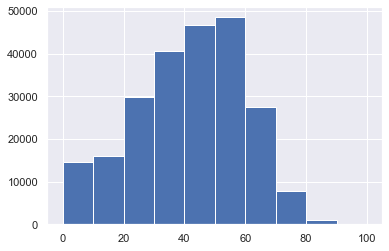

In [21]:
plt.hist(df['popularity'])
plt.show()

Looks relatively normal in distribution.

Now to make this a four-class classification model, I need to find how to split up the popularity score ranges. I will use .describe() to get the quartiles to maintain relatively equal class balance.

In [22]:
df["popularity"].describe()

count    232725.000000
mean         41.127502
std          18.189948
min           0.000000
25%          29.000000
50%          43.000000
75%          55.000000
max         100.000000
Name: popularity, dtype: float64

Now I have the boundary lines for the 4 different ranges: 
<br>0: < 29 
<br>1: >= 29 & < 43
<br>2: >= 43 & < 55
<br>3: >= 55

In [23]:
df["popularity"].mask(df['popularity'] < 29, 0, inplace=True)
df["popularity"].mask((df['popularity'] >= 29) & (df['popularity'] < 43), 1, inplace=True)
df["popularity"].mask((df['popularity'] >= 43) & (df['popularity'] < 55), 2, inplace=True)
df["popularity"].mask(df['popularity'] >= 55, 3, inplace=True)

In [19]:
df['popularity'].value_counts()

2    60223
3    58432
1    57660
0    56410
Name: popularity, dtype: int64

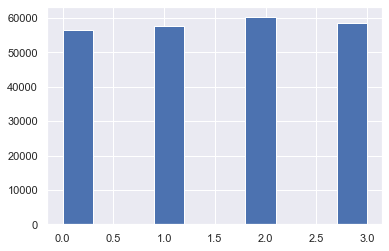

In [20]:
plt.hist(df['popularity'])
plt.show()

Good class balance confirmed.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 29 columns):
popularity            232725 non-null uint8
acousticness          232725 non-null float64
danceability          232725 non-null float64
duration_ms           232725 non-null uint32
energy                232725 non-null float64
instrumentalness      232725 non-null float64
liveness              232725 non-null float64
loudness              232725 non-null float64
mode                  232725 non-null uint8
speechiness           232725 non-null float64
tempo                 232725 non-null float64
valence               232725 non-null float64
time_signature_0/4    232725 non-null uint8
time_signature_1/4    232725 non-null uint8
time_signature_3/4    232725 non-null uint8
time_signature_4/4    232725 non-null uint8
time_signature_5/4    232725 non-null uint8
key_A                 232725 non-null uint8
key_A#                232725 non-null uint8
key_B                 232725 non-n

### Feature Importance

Now before moving forward, I will run a Decision Tree to see if there are any features that we should remove due to being insignificant.

In [25]:
from sklearn.tree import DecisionTreeClassifier

In [26]:
X = df.drop("popularity", 1)
y = df["popularity"]

In [27]:
dtc = DecisionTreeClassifier(random_state=1337)
%time dtc.fit(X, y)

Wall time: 3.47 s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1337, splitter='best')

In [28]:
print(sorted(zip(dtc.feature_importances_, X.columns), reverse=True))

[(0.19633276629394456, 'acousticness'), (0.10905834428101578, 'duration_ms'), (0.09754361899690125, 'speechiness'), (0.09111620912050852, 'loudness'), (0.08286675114717103, 'danceability'), (0.08211741814785146, 'valence'), (0.07135149495514385, 'energy'), (0.07033243965108922, 'instrumentalness'), (0.06853260792560915, 'tempo'), (0.06734465560602357, 'liveness'), (0.007990170077956195, 'mode'), (0.0053209740808377965, 'key_G'), (0.004999507116023714, 'key_C'), (0.004517210945394091, 'key_C#'), (0.004478360941931459, 'key_A'), (0.004427893861861855, 'key_D'), (0.004163914508639518, 'key_F'), (0.004097542497270174, 'key_B'), (0.004085860776505869, 'key_F#'), (0.0038846568434074634, 'key_E'), (0.0036576455576585853, 'key_G#'), (0.0033819067260732485, 'key_A#'), (0.0027292061914560776, 'time_signature_4/4'), (0.0021912479521020863, 'time_signature_3/4'), (0.0020664026320165946, 'key_D#'), (0.0009804025029662802, 'time_signature_5/4'), (0.00043079066264077, 'time_signature_1/4'), (0.0, 'ti

I think a good cutoff point here is for "mode" and everything below it, and they all just so happen to be the binary features. Dropping them shouldn't hurt accuracy, and will only improve runtime and memory usage.

In [29]:
X.drop(['time_signature_0/4', 'time_signature_1/4',
       'time_signature_3/4', 'time_signature_4/4', 'time_signature_5/4',
       'key_A', 'key_A#', 'key_B', 'key_C', 'key_C#', 'key_D', 'key_D#',
       'key_E', 'key_F', 'key_F#', 'key_G', 'key_G#'], 1, inplace=True)

In [30]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 11 columns):
acousticness        232725 non-null float64
danceability        232725 non-null float64
duration_ms         232725 non-null uint32
energy              232725 non-null float64
instrumentalness    232725 non-null float64
liveness            232725 non-null float64
loudness            232725 non-null float64
mode                232725 non-null uint8
speechiness         232725 non-null float64
tempo               232725 non-null float64
valence             232725 non-null float64
dtypes: float64(9), uint32(1), uint8(1)
memory usage: 17.1 MB


## Model Evaluation

### Train Test Split

Did some experimenting and found I got the best test scores without increasing training score by setting test size to 10000. I like using the "stratify" parameter so that the distribution of the outcome variable in the train and test sets remain virtually the same.

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, stratify=y) 

### Scaling

Going to use RobustScaler to scale all the features for any of the models that need things to be within the same scale.

In [32]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### K-Fold for Cross Validation

For similar reasons to my choice of the "stratify" parameter, I will be using the stratified version of the KFold class, so I make sure the distribution of the features remains virtually the same in each of the folds.

In [33]:
from sklearn.model_selection import StratifiedKFold

k_fold = StratifiedKFold(n_splits=5)

for train_indices, test_indices in k_fold.split(scaled_X_train, y_train):
    print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [ 43800  43804  43805 ... 222722 222723 222724] | test: [    0     1     2 ... 45102 45106 45117]
Train: [     0      1      2 ... 222722 222723 222724] | test: [43800 43804 43805 ... 89319 89322 89329]
Train: [     0      1      2 ... 222722 222723 222724] | test: [ 88672  88683  88686 ... 133809 133813 133818]
Train: [     0      1      2 ... 222722 222723 222724] | test: [133296 133300 133301 ... 178363 178370 178378]
Train: [     0      1      2 ... 178363 178370 178378] | test: [177914 177921 177926 ... 222722 222723 222724]


### Setting the Baseline with a Dummy Classifier

First let's see what a Dummy Classifier can do with the data so we know if the actual models are doing better than guessing at random.

In [34]:
from sklearn.dummy import DummyClassifier

In [35]:
dummy = DummyClassifier(strategy="uniform")
dummy.fit(scaled_X_train, y_train)
dummy.score(scaled_X_train, y_train), dummy.score(scaled_X_test, y_test)

(0.2510988887641711, 0.2373)

As predicted, it can randomly guess correctly 25% of the time, since there are 4 classes, or a 1/4 chance.

### SGD Classifier

Since this dataset has over 232K samples, Sci-kit Learn's <a href="https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html">"Choosing the right estimator"</a> documentation does not recommend any other form of classification, besides SGD.

In [36]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
sgdc = SGDClassifier()
%time sgdc.fit(scaled_X_train, y_train)
sgdc.score(scaled_X_train, y_train)

Wall time: 4.13 s


0.37818385901896956

In [38]:
y_pred = sgdc.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.59      0.47      2424
           1       0.33      0.36      0.34      2477
           2       0.32      0.09      0.14      2588
           3       0.41      0.48      0.44      2511

    accuracy                           0.38     10000
   macro avg       0.36      0.38      0.35     10000
weighted avg       0.36      0.38      0.35     10000



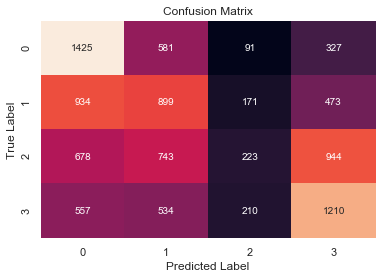

In [39]:
def plot_confusion_matrix(y_test, y_pred):
    sns.heatmap(
        confusion_matrix(y_test, y_pred), annot=True, cbar=False, fmt="d",
    )
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(y_test, y_pred)

In [40]:
from sklearn.model_selection import cross_val_score

cv = cross_val_score(sgdc, scaled_X_train, y_train, cv=k_fold, n_jobs=-1)
print(cv)
print(np.mean(cv))

[0.38388668 0.38574475 0.37840386 0.38476562 0.38222881]
0.3830059455430217


Interesting how much it struggles with recall on class 2 (>= 50% < 75%), and overall mediocre performance, with only 13% better than a dummy.

## Logistic Regression

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
logreg = LogisticRegression(
    solver='saga', # Using this solver because it's faster and the data is scaled
    multi_class="auto",
    n_jobs=-1
)
%time logreg.fit(scaled_X_train, y_train)
logreg.score(scaled_X_train, y_train)

Wall time: 1.64 s


0.41455157705690876

In [43]:
y_pred = logreg.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2424
           1       0.42      0.27      0.33      2477
           2       0.33      0.25      0.28      2588
           3       0.40      0.63      0.49      2511

    accuracy                           0.41     10000
   macro avg       0.41      0.42      0.40     10000
weighted avg       0.41      0.41      0.40     10000



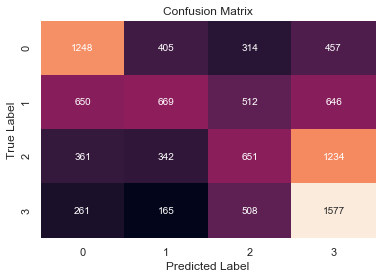

In [44]:
plot_confusion_matrix(y_test, y_pred)

In [45]:
cv = cross_val_score(logreg, scaled_X_train, y_train, cv=k_fold, n_jobs=-1)
print(cv)
print(np.mean(cv))

[0.41149797 0.41315524 0.41517567 0.41615032 0.41511764]
0.41421936590873454


A little bit better than SGD, but still unacceptable. And it still struggles with class 2, though not as much as in SGD.

## KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier

In [47]:
knc = KNeighborsClassifier()
%time knc.fit(scaled_X_train, y_train)
# When trying to get a training score to check for overfitting, doing a knc.score or a classification
# report on the training set causes the kernel to hang indefinitely.

Wall time: 273 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [48]:
y_pred = knc.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.54      0.54      2424
           1       0.41      0.40      0.40      2477
           2       0.46      0.44      0.45      2588
           3       0.56      0.61      0.58      2511

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.49      0.50      0.50     10000



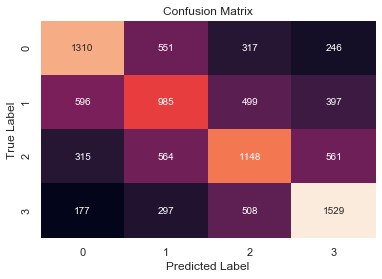

In [49]:
plot_confusion_matrix(y_test, y_pred)

In [50]:
cv = cross_val_score(knc, scaled_X_train, y_train, cv=k_fold, n_jobs=-1)
print(cv)
print(np.mean(cv))

[0.47125508 0.46851498 0.46838029 0.4684357  0.47312769]
0.46994275026710153


Definitely a step in the right direction. I'll try to change the weights parameter from the default to "distance" and see what happens.

In [51]:
knc = KNeighborsClassifier(weights="distance")
%time knc.fit(scaled_X_train, y_train)

Wall time: 276 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='distance')

In [52]:
y_pred = knc.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.51      0.57      2424
           1       0.51      0.44      0.47      2477
           2       0.60      0.61      0.60      2588
           3       0.65      0.87      0.75      2511

    accuracy                           0.61     10000
   macro avg       0.60      0.61      0.60     10000
weighted avg       0.60      0.61      0.60     10000



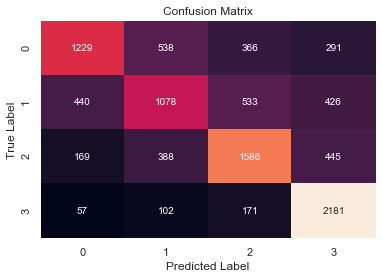

In [53]:
plot_confusion_matrix(y_test, y_pred)

In [54]:
cv = cross_val_score(knc, scaled_X_train, y_train, cv=k_fold, n_jobs=-1)
print(cv)
print(np.mean(cv))

[0.57801872 0.57126501 0.57077113 0.57051455 0.5743759 ]
0.5729890620855396


An overall 10% increase in F1 score, not bad.

## Decision Tree

I did a decision tree before, but I did not care about the accuracy, I just wanted to use it as a feature selection tool. Now I want to see how it did with test accuracy.

In [56]:
dtc = DecisionTreeClassifier(random_state=1337)
%time dtc.fit(scaled_X_train, y_train)
dtc.score(scaled_X_train, y_train)

Wall time: 2.9 s


0.9856908743966775

In [57]:
y_pred = dtc.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.49      0.52      2424
           1       0.45      0.41      0.43      2477
           2       0.59      0.60      0.60      2588
           3       0.72      0.86      0.78      2511

    accuracy                           0.59     10000
   macro avg       0.58      0.59      0.58     10000
weighted avg       0.58      0.59      0.58     10000



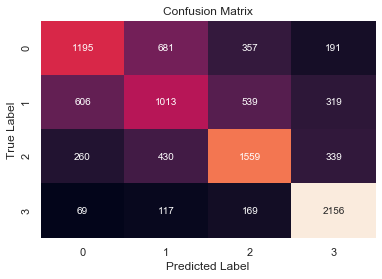

In [58]:
plot_confusion_matrix(y_test, y_pred)

In [59]:
cv = cross_val_score(knc, scaled_X_train, y_train, cv=k_fold, n_jobs=-1)
print(cv)
print(np.mean(cv))

[0.57801872 0.57126501 0.57077113 0.57051455 0.5743759 ]
0.5729890620855396


Starting to see a pattern with the classification report and confusion matrix. Interesting that the 75% and above song popularity range is easier for all the the models so far to predict. Perhaps there is less diversity, and thus less noise in the features of songs with high popularity? This would be interesting to plot for later.

## Random Forest

Now that it is apparent that decision trees do decent with this dataset, I want to see how an entire forest of trees can improve the test accuracy of the model.

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
rfc = RandomForestClassifier(class_weight="balanced",
    n_estimators=100, n_jobs=-1, random_state=1337)

%time rfc.fit(scaled_X_train, y_train)
rfc.score(scaled_X_train, y_train)

Wall time: 16.6 s


0.9856818947132113

In [62]:
y_pred = rfc.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.59      0.62      2424
           1       0.52      0.52      0.52      2477
           2       0.64      0.62      0.63      2588
           3       0.77      0.87      0.82      2511

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000



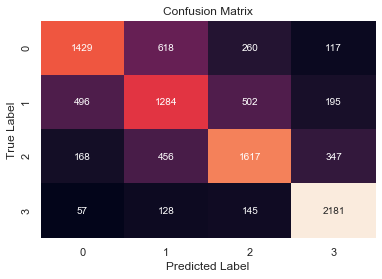

In [63]:
plot_confusion_matrix(y_test, y_pred)

In [64]:
cv = cross_val_score(rfc, scaled_X_train, y_train, cv=k_fold)
print(cv)
print(np.mean(cv))

[0.62194985 0.62384106 0.62188798 0.62104885 0.62140805]
0.6220271570645195


Very nice. About a 5% increase in test accuracy and f1-score over decision trees. Now to see if another implementation of decision trees in an ensemble, Extra Random Trees will provide any differences.

## Extra Random Trees

In [65]:
from sklearn.ensemble import ExtraTreesClassifier

In [66]:
xtc = ExtraTreesClassifier(class_weight="balanced",
    n_estimators=100, n_jobs=-1, random_state=1337) 

%time xtc.fit(scaled_X_train, y_train)
xtc.score(scaled_X_train, y_train)

Wall time: 11.5 s


0.9856908743966775

In [67]:
y_pred = xtc.predict(scaled_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.59      0.62      2424
           1       0.50      0.55      0.52      2477
           2       0.65      0.62      0.63      2588
           3       0.82      0.86      0.84      2511

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000



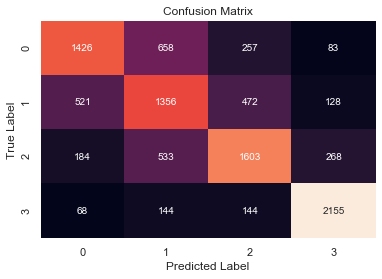

In [68]:
plot_confusion_matrix(y_test, y_pred)

In [69]:
cv = cross_val_score(xtc, scaled_X_train, y_train, cv=k_fold)
print(cv)
print(np.mean(cv))

[0.6288639  0.6255921  0.62503087 0.62479795 0.62574084]
0.6260051310405208


Overall the same in terms of average f1-score and slightly higher cross validation average accuracy, but the biggest difference is seen in the 2% increase in f1-score, and 5% increase in precision for the third class, and approximately 33% faster fitting time than the Random Forest. 

This model appears to be pretty good at recognizing songs with a popularity of 55 and above. Which I think is good, as if you get such a great prediction, you want it to be more accurate than the lower predictions, as to not get your hopes up. It is also pretty good at recogning the second highest class, which was the one that the non-decision tree classifiers struggled with the most. And it is third best at predicting songs in the lowest popularity class, lower than 29. The model gets the most confused with predicting if a song has a popularity of >= 29 < 43, or class 1. Perhaps increasing the amount of training data at a later time will resolve this.